In [4]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.api import add_constant

In [6]:
# Load Dataset
df = pd.read_csv("../data.csv")
df.head()

,y,z,selfrpt,race,gender,fgen,urban,mindset,test,sch_race,pov,size,schoolid
0,-0.365526,1,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,76
1,-0.159133,1,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,76
2,-0.255363,1,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,76
3,0.190908,1,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,76
4,-0.017629,1,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,76


In [7]:
# Baseline Linear Regression: y ~ z + covariates
X = df.drop(columns=['y', 'z', 'schoolid'])  # drop outcome, treatment, ID
X = pd.get_dummies(X, drop_first=True)
X_lm = add_constant(pd.concat([df['z'], X], axis=1))
y = df['y']

lm_model = sm.OLS(y, X_lm).fit()
print(lm_model.summary())

ate_lm = lm_model.params['z']
print(f"ATE (Linear Regression): {ate_lm:.4f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     382.5
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:49:25   Log-Likelihood:                -9545.9
No. Observations:               10391   AIC:                         1.912e+04
Df Residuals:                   10379   BIC:                         1.920e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1630      0.040    -29.211      0.0

In [8]:
# Estimate Propensity Scores (Logistic Regression)
X_ps = df.drop(columns=['y', 'z', 'schoolid'])
X_ps = pd.get_dummies(X_ps, drop_first=True)
t = df['z']

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_ps, t)
df['pscore'] = ps_model.predict_proba(X_ps)[:, 1]

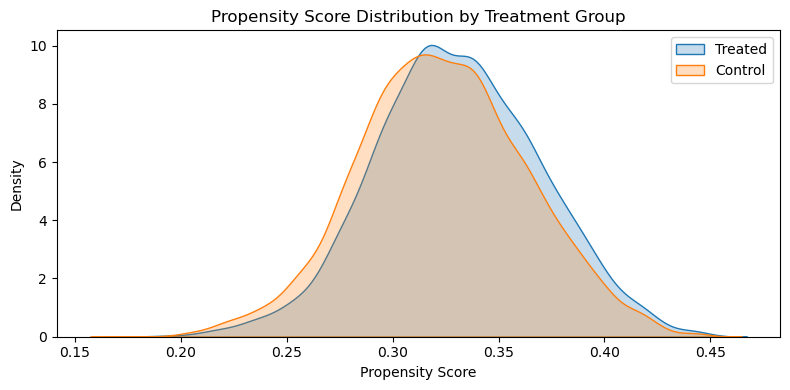

In [9]:
# Plot: Propensity Score Distribution
plt.figure(figsize=(8, 4))
sns.kdeplot(df[df.z == 1]['pscore'], label='Treated', fill=True)
sns.kdeplot(df[df.z == 0]['pscore'], label='Control', fill=True)
plt.title("Propensity Score Distribution by Treatment Group")
plt.xlabel("Propensity Score")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Inverse Probability Weighting (IPW)
df['ipw'] = np.where(df['z'] == 1, 1 / df['pscore'], 1 / (1 - df['pscore']))

X_ipw = add_constant(df['z'])
ipw_model = sm.WLS(df['y'], X_ipw, weights=df['ipw']).fit()
print(ipw_model.summary())

ate_ipw = ipw_model.params['z']
print(f"ATE (IPW): {ate_ipw:.4f}")

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            WLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     850.6
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          8.30e-180
Time:                        18:49:25   Log-Likelihood:                -11733.
No. Observations:               10391   AIC:                         2.347e+04
Df Residuals:                   10389   BIC:                         2.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1546      0.010    -15.382      0.0

In [13]:
# Linear regression confidence interval for ATE
conf_int_lm = lm_model.conf_int().loc['z']
print(f"95% CI (Linear Regression): [{conf_int_lm[0]:.4f}, {conf_int_lm[1]:.4f}]")

95% CI (Linear Regression): [0.3877, 0.4377]


In [14]:
# IPW confidence interval for ATE
conf_int_ipw = ipw_model.conf_int().loc['z']
print(f"95% CI (IPW): [{conf_int_ipw[0]:.4f}, {conf_int_ipw[1]:.4f}]")

95% CI (IPW): [0.3866, 0.4423]


C:\Users\vansh\AppData\Local\Temp\ipykernel_22296\909610148.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='z', y='y', palette="Set2")


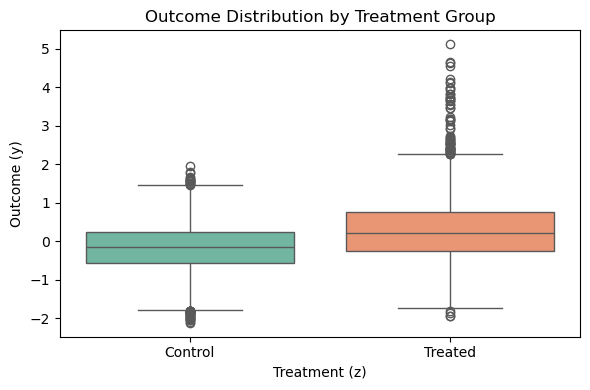

In [11]:
# Boxplot of outcome by treatment group
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='z', y='y', palette="Set2")
plt.title("Outcome Distribution by Treatment Group")
plt.xlabel("Treatment (z)")
plt.ylabel("Outcome (y)")
plt.xticks([0, 1], ["Control", "Treated"])
plt.tight_layout()
plt.show()

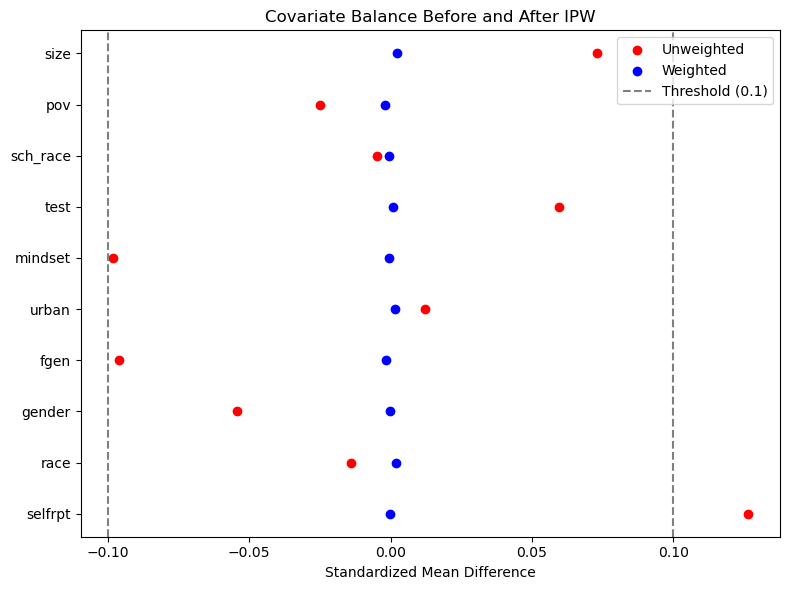

In [12]:
# Custom Love Plot – using standardized differences before and after IPW

def std_diff(X, treatment, weights=None):
    diffs = []
    for col in X.columns:
        if weights is not None:
            treated_mean = np.average(X[treatment == 1][col], weights=weights[treatment == 1])
            control_mean = np.average(X[treatment == 0][col], weights=weights[treatment == 0])
            treated_var = np.average((X[treatment == 1][col] - treated_mean)**2, weights=weights[treatment == 1])
            control_var = np.average((X[treatment == 0][col] - control_mean)**2, weights=weights[treatment == 0])
        else:
            treated_mean = X[treatment == 1][col].mean()
            control_mean = X[treatment == 0][col].mean()
            treated_var = X[treatment == 1][col].var()
            control_var = X[treatment == 0][col].var()
        
        pooled_sd = np.sqrt((treated_var + control_var) / 2)
        diffs.append((treated_mean - control_mean) / pooled_sd)
    return pd.Series(diffs, index=X.columns)

# Unweighted and weighted standardized differences
unweighted_diff = std_diff(X_ps, t)
weighted_diff = std_diff(X_ps, t, df['ipw'])

# Plot the standardized differences
plt.figure(figsize=(8, 6))
plt.scatter(unweighted_diff, range(len(unweighted_diff)), color='red', label='Unweighted')
plt.scatter(weighted_diff, range(len(weighted_diff)), color='blue', label='Weighted')
plt.axvline(0.1, color='gray', linestyle='--', label='Threshold (0.1)')
plt.axvline(-0.1, color='gray', linestyle='--')
plt.yticks(range(len(unweighted_diff)), X_ps.columns)
plt.xlabel('Standardized Mean Difference')
plt.title('Covariate Balance Before and After IPW')
plt.legend()
plt.tight_layout()
plt.show()